In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [2]:
# Create dfs for all relevant files
folder_path = '/users/connormulshine/Dropbox/UChicago/DS in Healthcare/datasetPracticeFusionDiabetes'

# List all csv files in the directory
filenames = os.listdir(folder_path)

# Remove '.csv' from the name of each file
def extract_name_files(text):
    name_file = text.replace('.csv', '').lower()
    return name_file

# Create a list that will be used to name dataframes
names_of_files = list(map(extract_name_files,filenames))

# Save each csv in a df
for i in range(0,len(names_of_files)):
    exec(names_of_files[i] + " =  pd.read_csv(folder_path+'/'+filenames[i])")
    
# List all dfs
names_of_files

['training_syncmedication',
 'synccondition',
 'training_syncpatient',
 'training_syncdiagnosis',
 'training_syncpatientsmokingstatus',
 'test_syncpatient',
 'training_syncpatient_orig',
 'training_syncallergy',
 'training_syncprescription',
 'training_synclabobservation',
 'training_synctranscript',
 'training_syncpatientcondition',
 'training_syncimmunization',
 'syncsmokingstatus',
 'training_synctranscriptmedication',
 'training_synclabresult',
 'training_synclabpanel',
 'training_synctranscriptallergy',
 'training_synctranscriptdiagnosis']

In [3]:
# The df appears to be picking up a lot of blank records at the bottom
len(training_syncpatient)

9871

In [4]:
# To fix, delete all records for which there is no patient ID
training_syncpatient = training_syncpatient.dropna(subset=['PatientGuid'])
len(training_syncpatient)

6600

### PATIENT ('training_syncpatient')
##### Clean up central patient database

In [5]:
training_syncpatient.head()

,PatientGuid,DMIndicator,Gender,YearOfBirth,State,PracticeGuid
0,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0.0,M,1929.0,SD,7BF4DAD8-5F67-4985-B911-20C9E89A3737
1,C6746626-6783-4650-A58F-00065649139A,0.0,F,1985.0,TX,E7101967-2FF1-4B0F-8129-B0B429D1D15C
2,E05C6E8F-779F-4594-A388-000C635AE4D3,0.0,F,1984.0,NJ,FC01A799-1CAF-464F-A86F-8A666AB86F32
3,EAEBD216-F847-4355-87B2-000D942E08F0,0.0,M,1959.0,OH,EEBC95EF-79BE-4542-892E-98D3166BAB20
4,C7F10A80-4934-42D2-8540-000FBEBA75C8,0.0,F,1990.0,FL,677BA32E-B4C4-48F2-86E4-08C42B135401


In [6]:
# Drop columns that aren't needed
training_syncpatient = training_syncpatient.drop('State', axis=1)
training_syncpatient = training_syncpatient.drop('PracticeGuid', axis=1)

# Encode gedner
training_syncpatient['Gender'] = training_syncpatient['Gender'].map({'M': 1, 'F': 0})

### ALLERGIES ('training_syncallergy')
##### Flag if patient has any type of allergy

In [7]:
# Create a dummy variable in patient df based on whether the patient has at least one allergy
training_syncpatient['any_allergy'] = training_syncpatient['PatientGuid'].isin(training_syncallergy['PatientGuid']).astype(int)
training_syncpatient['any_allergy'].value_counts()

0    5464
1    1136
Name: any_allergy, dtype: int64

### CONDITIONS ('training_syncpatientcondition')
##### Flag if patient has any type of condition

In [8]:
# Create a dummy variable in patient df based on whether the patient has at least one condition
training_syncpatient['any_condition'] = training_syncpatient['PatientGuid'].isin(training_syncpatientcondition['PatientGuid']).astype(int)
training_syncpatient['any_condition'].value_counts()

0    4727
1    1873
Name: any_condition, dtype: int64

### SMOKING ('training_syncpatientsmokingstatus')
##### Flag if patient is a non-smoker, light smoker, or heavy smoker

In [9]:
# Move 'Description' column into the 'training_syncpatientsmokingstatus' df
training_syncpatientsmokingstatus = training_syncpatientsmokingstatus.merge(syncsmokingstatus, on='SmokingStatusGuid', how='left')

# Map descriptions of smoking status. 0 = non-smoker, 1 = light smoker, 2 = heavy smoker.
# Not going to map 'Current status unknown', as we'll get a '0' across all categories (same as N/A)
smoker_flags = {
    "Not a current tobacco user": 0,
    "0 cigarettes per day (previous smoker)": 1,
    "Few (1-3) cigarettes per day": 1, 
    "2 or more packs per day": 2,
    "Up to 1 pack per day": 1, 
    "1-2 packs per day": 2, 
    "Current Tobacco user": 1,
    "0 cigarettes per day (non-smoker or less than 100 in lifetime)": 0,
    "Current status unknown": np.nan}

training_syncpatientsmokingstatus['smoker'] = training_syncpatientsmokingstatus['Description'].replace(smoker_flags)
training_syncpatientsmokingstatus_encoded = pd.get_dummies(training_syncpatientsmokingstatus['smoker'],
                                                          prefix='smoker')

# Rename columns
training_syncpatientsmokingstatus_encoded.rename(columns={'smoker_0.0': 'non_smoker', 
                                                          'smoker_1.0': 'light_smoker', 
                                                          'smoker_2.0': 'heavy_smoker'}, inplace=True)

# Isolate patient_id
patient_id_smoking = training_syncpatientsmokingstatus['PatientGuid']

# Create a new df, which includes patient_id and smoker flag columns
training_syncpatientsmokingstatus_final = pd.concat([patient_id_smoking, 
                                                     training_syncpatientsmokingstatus_encoded], axis=1)

# Merge encoded diagnoses into patient df and replace any null values with '0'
training_syncpatient = training_syncpatient.merge(training_syncpatientsmokingstatus_final, on='PatientGuid', how='left')
training_syncpatient = training_syncpatient.fillna(0)

### IMMUNIZATIONS ('training_syncimmunization')
##### has 8 records total, so we will exclude from our model

### PRIOR DIAGNOSES ('training_syncdiagnosis')
##### Mapping by chapter of ICD Code

In [10]:
# Convert ICD Codes into their chapters, so we have a better idea of what types of diagnoses we're working with
from icdmappings import Mapper
mapper = Mapper()
training_syncdiagnosis['icd_chapter'] = mapper.map(training_syncdiagnosis['ICD9Code'], source='icd9', target='chapter')

# Drop records in which the same patient was given the same diagnosis more than once
training_syncdiagnosis_no_dupes = training_syncdiagnosis.drop_duplicates(subset=['PatientGuid', 'icd_chapter'])

print('Original # of Records:', len(training_syncdiagnosis))
print('# of Records after removing duplicate diagnoses:', len(training_syncdiagnosis_no_dupes))

Original # of Records: 94830
# of Records after removing duplicate diagnoses: 52992


In [11]:
chapter_counts = training_syncdiagnosis_no_dupes['icd_chapter'].value_counts()
chapter_counts

3     6027
16    5659
7     5276
8     5166
13    5017
18    4024
5     3787
6     3631
9     3212
10    3172
12    2369
1     2054
17    1535
4      940
2      791
14     111
11     105
19     105
15       9
Name: icd_chapter, dtype: int64

In [12]:
# Eliminate the records for which there are very few 'icd_chapter' codes
n_chapters = 750

selected_chapters = chapter_counts[chapter_counts >= n_chapters].index
training_syncdiagnosis_top = training_syncdiagnosis_no_dupes[training_syncdiagnosis_no_dupes['icd_chapter'].isin(selected_chapters)]

print('Total ICD Chapters included:     ', len(training_syncdiagnosis_top['icd_chapter'].unique()))
print('Total patient diagnoses included:', len(training_syncdiagnosis_top))

Total ICD Chapters included:      15
Total patient diagnoses included: 52660


In [13]:
# Drop columns we don't need
keep_cols = ['PatientGuid', 'icd_chapter']
training_syncdiagnosis_simple = training_syncdiagnosis_top.loc[:,keep_cols]

# One-hot encode based on ICD chapter
training_syncdiagnosis_encoded = pd.get_dummies(training_syncdiagnosis_simple, columns=['icd_chapter'])

# Group records together by patient
training_syncdiagnosis_final = training_syncdiagnosis_encoded.groupby('PatientGuid').max()

# Merge encoded diagnoses into patient df
training_syncpatient = training_syncpatient.merge(training_syncdiagnosis_final, on='PatientGuid', how='left')

### MEDICATIONS ('training_syncmedication')

##### Including only medications with a large enough n
##### All other medications likely do not have enough data to influence our model

In [14]:
# Drop records in which the same patient was prescribed the same medication more than once
training_syncmedication_no_dupes = training_syncmedication.drop_duplicates(subset=['PatientGuid', 'NdcCode'])

print('Original # of Records:                  ', len(training_syncmedication))
print('# of Records after removing duplicates: ', len(training_syncmedication_no_dupes))

Original # of Records:                   44520
# of Records after removing duplicates:  43890


In [15]:
# Ignoring all medications that have been prescribed less than 10 times
# Then, taking medications which are greater than the mean of remaining medications + 2 SD's
ndccode_counts = training_syncmedication_no_dupes['NdcCode'].value_counts()
ndccode_counts_gt_10 = ndccode_counts[ndccode_counts > 10]
n_medications = np.mean(ndccode_counts_gt_10) + 2 * np.std(ndccode_counts_gt_10)

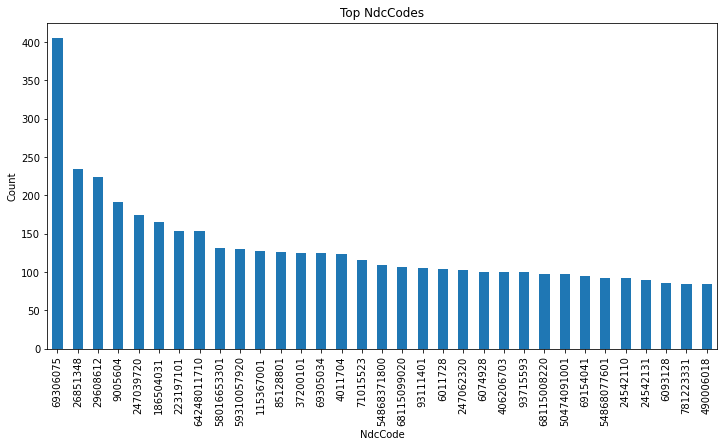

In [16]:
# View how often medications are prescribed using a bar chart
top_ndccodes = ndccode_counts[ndccode_counts >= n_medications]

plt.figure(figsize=(12, 6))
top_ndccodes.plot(kind='bar')
plt.title("Top NdcCodes")
plt.xlabel("NdcCode")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [17]:
selected_ndccodes = top_ndccodes.index
training_syncmedication_top = training_syncmedication[training_syncmedication['NdcCode'].isin(selected_ndccodes)]

print('Total medications included: ', len(training_syncmedication_top['NdcCode'].unique()))
print('Total patients included:    ', len(training_syncmedication_top))

Total medications included:  33
Total patients included:     4442


In [18]:
# One-hot encode based on NDC Code
training_syncmedication_encoded = pd.get_dummies(training_syncmedication_top, columns=['NdcCode'])

# Group records together by patient
training_syncmedication_final = training_syncmedication_encoded.groupby('PatientGuid').max()

# Drop columns that aren't needed
drop_med_cols = ['MedicationGuid', 'Schedule', 'DiagnosisGuid', 'UserGuid', 'MedicationName', 'MedicationStrength']
training_syncmedication_final = training_syncmedication_final.drop(drop_med_cols, axis=1)

# Merge encoded diagnoses into patient df
training_syncpatient = training_syncpatient.merge(training_syncmedication_final, on='PatientGuid', how='left')

### TRANSCRIPT ('training_synctranscript')
##### Keeping 'BMI', 'SystolicBP', & 'DiastolicBP'

In [19]:
len(training_synctranscript)

131031

In [20]:
# View how many values are missing
training_synctranscript.isna().sum() / training_synctranscript.shape[0]

TranscriptGuid        0.000000
PatientGuid           0.000000
VisitYear             0.000000
Height                0.541727
Weight                0.000000
BMI                   0.000000
SystolicBP            0.346872
DiastolicBP           0.346872
RespiratoryRate       0.609314
HeartRate             1.000000
Temperature           0.618151
PhysicianSpecialty    0.001381
UserGuid              0.000000
dtype: float64

In [21]:
pd.set_option('display.float_format', '{:,.2f}'.format)

# Drop columns we don't need
keep_cols_2 = ['PatientGuid', 'BMI', 'SystolicBP', 'DiastolicBP']
training_synctranscript_simple = training_synctranscript.loc[:,keep_cols_2]

# Group records together by patient
training_synctranscript_final = training_synctranscript_simple.groupby('PatientGuid').mean()

# Drop any records with 'NaN' values
training_synctranscript_final = training_synctranscript_final.dropna()

# Merge encoded diagnoses into patient df
training_syncpatient = training_syncpatient.merge(training_synctranscript_final, on='PatientGuid', how='left')

### LAB OBSERVATIONS ('training_synclabobservation')
##### Flag for patients with at least one abnormal test result

In [22]:
len(training_synclabresult['PatientGuid'].unique())

875

In [23]:
# Merge 'PatientGuid' over to 'training_synclabpanel' df
training_synclabpanel_new = training_synclabpanel.merge(training_synclabresult[['LabResultGuid','PatientGuid']], 
                                                        on='LabResultGuid', how='left')

# Merge 'patient_exists' over to 'training_synclabobservation_new' df
training_synclabobservation_new = training_synclabobservation.merge(training_synclabpanel_new[['LabPanelGuid','PatientGuid']], 
                                                      on='LabPanelGuid', how='left')

# Keep only records where the panel returned an abnormal result
training_synclabobservation_new = training_synclabobservation_new[training_synclabobservation_new['IsAbnormalValue'] != 0]

# Merge into 'training_syncpatient' df
training_syncpatient['abnormal_tests'] = training_syncpatient['PatientGuid'].isin(training_synclabobservation_new['PatientGuid']).astype(int)

training_syncpatient['abnormal_tests'].value_counts()

0    6543
1     382
Name: abnormal_tests, dtype: int64

### 'training_syncpatient' IS NOW READY TO BE MODELED

In [24]:
pd.set_option('display.float_format', '{:,.2f}'.format)
training_syncpatient.describe()

,DMIndicator,Gender,YearOfBirth,any_allergy,any_condition,non_smoker,light_smoker,heavy_smoker,icd_chapter_1,icd_chapter_10,...,NdcCode_54868371800,NdcCode_58016653301,NdcCode_59310057920,NdcCode_64248011710,NdcCode_68115008220,NdcCode_68115099020,BMI,SystolicBP,DiastolicBP,abnormal_tests
count,"6,925.00","6,925.00","6,925.00","6,925.00","6,925.00","6,925.00","6,925.00","6,925.00","6,923.00","6,923.00",...,"2,136.00","2,136.00","2,136.00","2,136.00","2,136.00","2,136.00","6,924.00","6,924.00","6,924.00","6,925.00"
mean,0.19,0.43,"1,957.41",0.19,0.29,0.32,0.14,0.01,0.20,0.32,...,0.04,0.04,0.04,0.05,0.03,0.04,19.51,126.14,76.81,0.06
std,0.39,0.50,17.45,0.39,0.46,0.47,0.35,0.10,0.40,0.47,...,0.19,0.20,0.20,0.21,0.17,0.19,60.24,13.62,8.22,0.23
min,0.00,0.00,"1,922.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.12,77.00,40.00,0.00
25%,0.00,0.00,"1,944.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,7.87,117.00,71.50,0.00
50%,0.00,0.00,"1,957.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,14.75,125.40,76.75,0.00
75%,0.00,1.00,"1,970.00",0.00,1.00,1.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,23.03,134.18,81.89,0.00
max,1.00,1.00,"1,994.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,"2,352.89",201.33,132.21,1.00


In [25]:
training_syncpatient = training_syncpatient.drop('PatientGuid', axis=1)
training_syncpatient = training_syncpatient.fillna(0)
len(training_syncpatient.columns)

60

## MODELING

### LOGISTIC REGRESSION

In [26]:
training_syncpatient.columns

Index(['DMIndicator', 'Gender', 'YearOfBirth', 'any_allergy', 'any_condition',
       'non_smoker', 'light_smoker', 'heavy_smoker', 'icd_chapter_1',
       'icd_chapter_10', 'icd_chapter_12', 'icd_chapter_13', 'icd_chapter_16',
       'icd_chapter_17', 'icd_chapter_18', 'icd_chapter_2', 'icd_chapter_3',
       'icd_chapter_4', 'icd_chapter_5', 'icd_chapter_6', 'icd_chapter_7',
       'icd_chapter_8', 'icd_chapter_9', 'NdcCode_4011704', 'NdcCode_6011728',
       'NdcCode_6074928', 'NdcCode_6093128', 'NdcCode_9005604',
       'NdcCode_24542110', 'NdcCode_24542131', 'NdcCode_26851348',
       'NdcCode_29608612', 'NdcCode_37200101', 'NdcCode_69154041',
       'NdcCode_69305034', 'NdcCode_69306075', 'NdcCode_71015523',
       'NdcCode_85128801', 'NdcCode_93111401', 'NdcCode_93715593',
       'NdcCode_115367001', 'NdcCode_186504031', 'NdcCode_223197101',
       'NdcCode_247039720', 'NdcCode_247062320', 'NdcCode_406206703',
       'NdcCode_490006018', 'NdcCode_781223331', 'NdcCode_50474091001

In [27]:
# Split into Train & Test (75/25)
train, test = train_test_split(training_syncpatient, test_size = 0.25, random_state = 42)

# Separate dependent variable ('DMIndicator') from predictors
y_train = train['DMIndicator']
X_train = train.drop('DMIndicator', axis=1)

y_test = test['DMIndicator']
X_test = test.drop('DMIndicator', axis=1)

# Create a StandardScaler instance
scaler = StandardScaler()

# Define which columns to scale
columns_to_scale = ['BMI', 'SystolicBP', 'DiastolicBP', 'YearOfBirth']

X_train_scaled = X_train.copy()  # Create a copy of X_train
X_test_scaled = X_test.copy()  # Create a copy of X_test

# Fit and transform the non-binary columns for the training set
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_scaled[columns_to_scale])

# Transform the test set in the same way
X_test_scaled[columns_to_scale] = scaler.transform(X_test_scaled[columns_to_scale])

# Create Logistic Regression model
lr_model = LogisticRegression(max_iter=100000)

# Select the best features for the model
num_features = 40

rfe = RFE(estimator = lr_model, n_features_to_select=num_features, step=1)
rfe.fit(X_train_scaled, y_train)

# Use only the selected features for both training and test data
selected_features = X_train_scaled.columns[rfe.support_]
X_train_optimal = X_train_scaled[selected_features]
X_test_optimal = X_test_scaled[selected_features]

# Define the hyperparameter grid for GridSearchCV
param_grid = {'penalty': ['l2'], 'C': [0.01, 0.1, 1.0]}

# Run GridSearchCV to find the optimal parameter values 
grid_search = GridSearchCV(lr_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_optimal, y_train)

# Create a new LR model, only using the optimal parameters
lr_model = grid_search.best_estimator_
lr_model.fit(X_train_optimal, y_train)

# Generate predictions on the train & test sets
y_train_pred = lr_model.predict_proba(X_train_optimal)
y_test_pred = lr_model.predict_proba(X_test_optimal)

# Calculate and print Brier Score
lr_brier_score_train = brier_score_loss(y_train, y_train_pred[:,1])
lr_brier_score_test = brier_score_loss(y_test, y_test_pred[:,1])

print('Brier Training Score:  ', round(lr_brier_score_train,4))
print('Brier Test Score:      ', round(lr_brier_score_test,4))

Brier Training Score:   0.1301
Brier Test Score:       0.144


### Support Vector Machine

In [28]:
# Create SVC model
svc_model = SVC(probability=True)
svc_model.fit(X_train_optimal, y_train)

# Generate predictions on the train & test sets
svm_train_pred = svc_model.predict_proba(X_train_optimal)
svm_test_pred = svc_model.predict_proba(X_test_optimal)

# Calculate and print Brier Score
svm_brier_score_train = brier_score_loss(y_train, svm_train_pred[:,1])
svm_brier_score_test = brier_score_loss(y_test, svm_test_pred[:,1])

print('Brier Training Score:', round(svm_brier_score_train,4))
print('Brier Test Score:    ', round(svm_brier_score_test,4))

Brier Training Score: 0.1141
Brier Test Score:     0.1546


### ENSEMBLE MODEL

In [29]:
# Generate predictions on the train & test sets
ensemble_train_pred = (y_train_pred + svm_train_pred) / 2
ensemble_test_pred = (y_test_pred + svm_test_pred) / 2

# Calculate and print Brier Score
ensemble_brier_score_train = brier_score_loss(y_train, ensemble_train_pred[:,1])
ensemble_brier_score_test = brier_score_loss(y_test, ensemble_test_pred[:,1])

print('Brier Training Score:', round(ensemble_brier_score_train,4))
print('Brier Test Score:    ', round(ensemble_brier_score_test,4))

Brier Training Score: 0.1188
Brier Test Score:     0.1463


### MODEL COMPARISON

In [30]:
data = [
    ["LR model:", round(lr_brier_score_train, 4), round(lr_brier_score_test, 4)],
    ["SVM model:", round(svm_brier_score_train, 4), round(svm_brier_score_test, 4)],
    ["Ensemble model:", round(ensemble_brier_score_train, 4), round(ensemble_brier_score_test, 4)],
]

headers = ["Model", "Brier Score (Train)", "Brier Score (Test)"]

# Calculate the maximum width for each column to format the table
max_col_widths = [max(len(str(item)) for item in col) for col in zip(*data, headers)]

# Create the table header
table_header = "  ".join(f"{header:<{width}}" for header, width in zip(headers, max_col_widths))
table_divider = "-" * len(table_header)

# Create the table rows
table_rows = [table_header, table_divider]  # Header and divider lines
table_rows.extend("  ".join(f"{item:<{width}}" for item, width in zip(row, max_col_widths)) for row in data)

# Print the table
for row in table_rows:
    print(row)

Model            Brier Score (Train)  Brier Score (Test)
--------------------------------------------------------
LR model:        0.1301               0.144             
SVM model:       0.1141               0.1546            
Ensemble model:  0.1188               0.1463            


### Based on the training results, we will use the Logistic Regression model, due to its superior performance on the test set.

In [31]:
# Drop columns that aren't needed
test_syncpatient = test_syncpatient.drop('State', axis=1)
test_syncpatient = test_syncpatient.drop('PracticeGuid', axis=1)

# Encode gender
test_syncpatient['Gender'] = test_syncpatient['Gender'].map({'M': 1, 'F': 0})

# Create a dummy variable in patient df based on whether the patient has at least one allergy
test_syncpatient['any_allergy'] = test_syncpatient['PatientGuid'].isin(training_syncallergy['PatientGuid']).astype(int)

# Create a dummy variable in patient df based on whether the patient has at least one condition
test_syncpatient['any_condition'] = test_syncpatient['PatientGuid'].isin(training_syncpatientcondition['PatientGuid']).astype(int)

# Merge columns related to patient smoking status
test_syncpatient = test_syncpatient.merge(training_syncpatientsmokingstatus_final, on='PatientGuid', how='left')
test_syncpatient = test_syncpatient.fillna(0)

# Merge encoded diagnoses into patient df
test_syncpatient = test_syncpatient.merge(training_syncdiagnosis_final, on='PatientGuid', how='left')

# Merge encoded diagnoses into patient df
test_syncpatient = test_syncpatient.merge(training_syncmedication_final, on='PatientGuid', how='left')

# Merge encoded diagnoses into patient df
test_syncpatient = test_syncpatient.merge(training_synctranscript_final, on='PatientGuid', how='left')

# Merge into 'test_syncpatient' df & clean df
test_syncpatient['abnormal_tests'] = test_syncpatient['PatientGuid'].isin(training_synclabobservation_new['PatientGuid']).astype(int)
test_syncpatient = test_syncpatient.fillna(0)
final_pred = pd.DataFrame({'PatientGud': test_syncpatient['PatientGuid']})
test_syncpatient = test_syncpatient.drop('PatientGuid', axis=1)

In [32]:
# Scale test data and run it through chosen (Logistic Regression) model
X_model = test_syncpatient
X_model_scaled = X_model.copy()
X_model_scaled[columns_to_scale] = scaler.transform(X_model_scaled[columns_to_scale])
X_model_optimal = X_model_scaled[selected_features]
lr_model_pred = lr_model.predict_proba(X_model_optimal)

# Convert final predictions on test set to CSV
final_pred['DMIndicatorForecast'] = lr_model_pred[:,1]
final_pred.to_csv('test_SyncPatientForecast.csv', index=False)